MOURRE Grégoire - LECLERC Marceau - GenAI 2024 project

# Approach
This notebook will present how we conducted our experiments, and will evaluate our various models. The full code repository - with pre-trained models- is available [here](https://github.com/marssoo/GenAI2025-DiffInstruct).

## Outline of the approach
We want to apply [DiffInstruct](https://arxiv.org/abs/2305.18455) to finetune a generator (obtained with adversarial training) with a better diffusion model (DM). The main goal of DiffInstruct is to distill the knowledge of a DM (typically very powerful but long to sample from) into a weaker model from which sampling is fast. DiffInstruct (DI), as presented in the original paper, can be applied to single-step DMs as well as generators as long as the generated samples are differentiable with respect to the generator's parameters. In the associated [Github](https://github.com/pkulwj1994/diff_instruct/tree/main), the authors focus on single step DMs. We will here focus on a generated trained with an adversarial procedure. The code that implements the DI method (in `DiffInstruct.py`) is heavily inspired from the previous Github repository. 

We will here provide an overview of:
- The training of our teacher DM.
- The training of our student generator.
- The distillation of the teacher's knowledge to the student by DI.
- Evaluate all these models to see how they compare.

## Pre-trainings
Here we detail the obtention of the DM and the generator. We will use FashionMNIST for dataset. This will allow efficiency both in the training and in sampling. Using a more complex dataset is besides our point, we want to replicate and showcase DI.

### Diffusion model
We pre trained our teacher model. It has the architecture of a simple UNet and relies on a sinusoidal embedding for the timesteps.

Training can be reproduced with the following command (from the root of this repo):
```
python3 trainDM.py
```
Some parameters can be changed. To replicate a model with the same architecture as the one we ended up with, please run :

```
python3 trainDM.py --num_layers 4 --hidden_channels 128 --timesteps 2000 --epohs 150
```
In our case, early stopping was triggered after 110 epochs. The early stopping was done according to a validation procedure relying on 20% of the dataset. 
The DM will be saved in `DM_models`. We provide a visualization of the training logs in the next cell.

Bear in mind that this training took a long time (>1 hour with a batch size of 128 on a GPU). For your information, 4GB of vRAM should be enough, and if not reducing the batch size to 64 will definetly be.

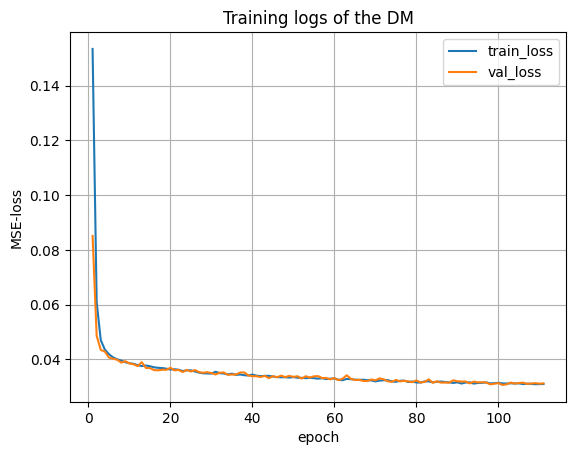

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
DM_logs = pd.read_csv('DM_models/UNet_4layers_128hc_2000steps_logs.csv')
DM_logs.plot('epoch')
plt.grid(True)
plt.ylabel("MSE-loss")
plt.title("Training logs of the DM")
plt.savefig("figures/DM_training_logs.jpg", dpi=150)
plt.show()


Now let's load and sample from this model.

In [2]:
from DM import UNetDM
from train_DM import cosine_beta_schedule
import torch

def load_DM(model_path, input_channels, hidden_channels, num_layers, timesteps, device):
    model = UNetDM(input_channels, hidden_channels, num_layers, timesteps).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def sample_DM(model, num_samples, timesteps, device):
    betas = torch.tensor(cosine_beta_schedule(timesteps)).to(device)
    samples = model.sample_images(num_samples=num_samples, betas=betas, device=device)
    return samples

def visualize_images(images, nrow=5, save_name=None):
    from torchvision.utils import make_grid
    grid = make_grid(images, nrow=nrow, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis('off')
    if save_name:
        plt.savefig('figures/' + save_name + '.jpg', dpi=150)
    plt.show()

DM_path = "DM_models/UNet_4layers_128hc_2000steps.pth"  # Path to the trained model
input_channels = 1
hidden_channels = 128
num_layers = 4
timesteps = 2000
#100 samples will take around 4 minutes but we will need them to have a somewhat decent sample size for later quantitative evaluation
num_samples = 100
n_display = 20
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
DM = load_DM(DM_path, input_channels, hidden_channels, num_layers, timesteps, device)
DM_samples = sample_DM(DM, num_samples, timesteps, device)
DM_samples = torch.stack(DM_samples)
DM_samples = DM_samples.reshape(-1, 1, 28, 28)

/tmp/ipykernel_66949/4248070483.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


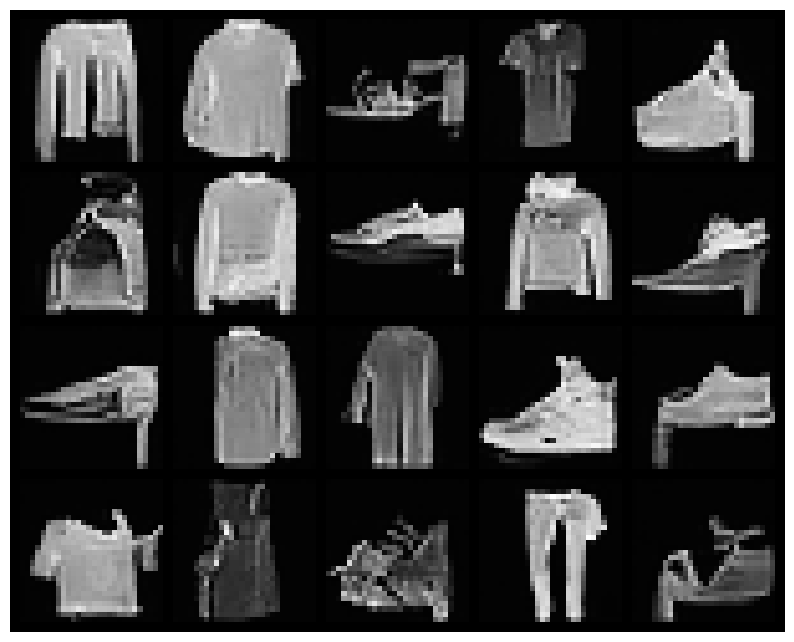

In [4]:
visualize_images(DM_samples[:n_display])

We did expect more from such a DM. However, the objects are still somewhat recognizable and do offer a clear structure. We will stick with as or teacher model.

### Adversarial pre-training of the generator
We implemented a generator that samples images of size 1x28x28 from a latent space of dimension 128. It incorporates a shrinking convolutional architectures of 3 layers. A discriminator with a mirror architecture was also implemented for the adversarial procedure.

Training is quite fast and can achieve results visibly better than the DM within 15 epochs. However here we want our generator to be worse than our DM, in order for it to have something to learn from the latter. To that end, we purposefully ran the adversarial training for 3 epochs only. This yields a very imperfect generator that still is good enough to produce what looks like objects that could be improved. This shortcut allows us to have somewhat of a shot at reproducing what is described in the DI paper for transferring a DM knowledge into a GAN.

Training can be reproduced as follows:

```
python3 train_GAN.py --latent_dim 128 --epochs 3
```

Let's now load and sample from this student model.

In [5]:
from GAN import Generator
def sample_generator(generator, num_samples, latent_dim, device):
    z = torch.randn((num_samples, latent_dim), device=device)
    with torch.no_grad():
        fake_images = generator(z).cpu()
    return fake_images

def load_generator(model_path, latent_dim, img_channels, hidden_dim, device):
    generator = Generator(latent_dim, img_channels, hidden_dim).to(device)
    generator.load_state_dict(torch.load(model_path, map_location=device))
    generator.eval()
    return generator
    
generator_path = "GAN_models/best_generator.pth"
latent_dim = 128
img_channels = 1
hidden_dim = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

generator = load_generator(generator_path, latent_dim, img_channels, hidden_dim, device)

/tmp/ipykernel_66949/2354721227.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(model_path, map_location=device))


In [6]:
gen_samples_pretrained = sample_generator(generator, num_samples, latent_dim, device)

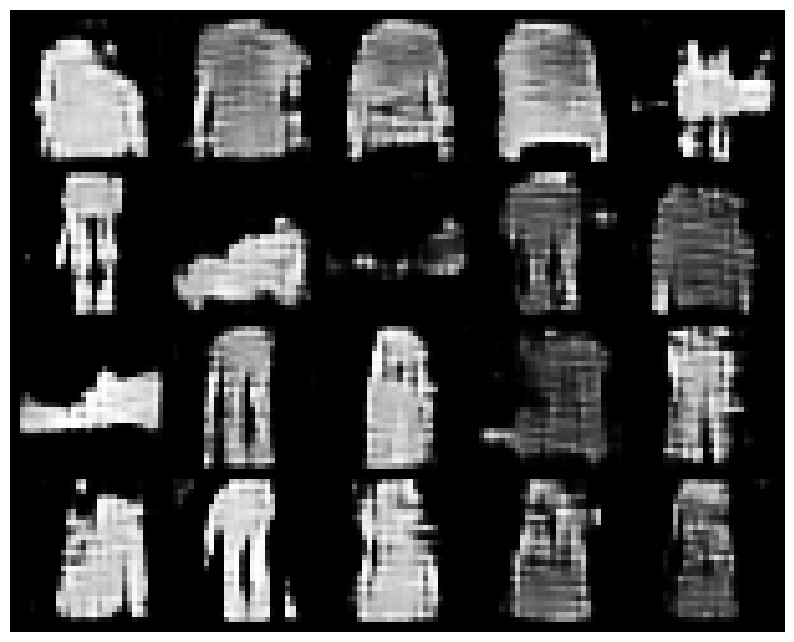

In [7]:
visualize_images(gen_samples_pretrained[:n_display])

The images could indeed use some refinement. However the shapes and the contrast are not just noise, making this generator a decent starting point and strong candidate for further tuning.

## DiffInstruct procedure

We reimplimented the DI procedure from the paper itself and somewhat replicating the structure in [its repository](https://github.com/pkulwj1994/diff_instruct/tree/main). The `DiffInstruct.py` script holds both the training loop as well as both losses:
- `loss_phi` is the function associated to the update of the implicit model, initialized with the weights of our teacher DM (as is the frozen DM used to get the original scores).
- `loss_theta` is the function associated to the update of the generator's parameters. The authors use it as a loss, even though it is purely derived from the gradient of the IKL divergence, object of the paper.

The DI procedure can be ran as follows:
```
python3 DiffInstruct.py
```
It does accept several parameters, but the default ones are the best we found. The generator so-instructed is saved in `DI_models/`.

Let's sample from it:

In [8]:
DI_gen_path = "DI_models/tracking/DI_generator_default_round_45.pth"
generator = load_generator(DI_gen_path, latent_dim, img_channels, hidden_dim, device)

/tmp/ipykernel_66949/2354721227.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(model_path, map_location=device))


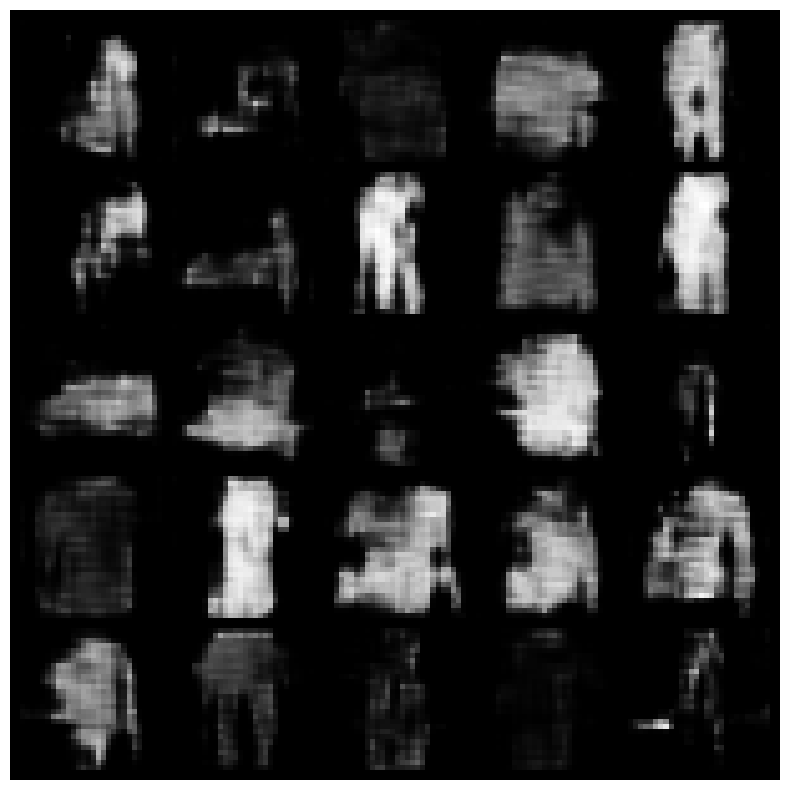

In [9]:
gen_samples_DI = sample_generator(generator, num_samples, latent_dim, device)
visualize_images(gen_samples_DI[:25])

These results are curious and will be explained when digging more into the training procedure step by step.


## Quantitative analysis

Even though we commented as humans, we still want to quantify the quality of these various sets of samples in order to ground our appreciation. To do that, we will use [Inceptionv3](https://pytorch.org/vision/stable/models/generated/torchvision.models.inception_v3.html) (commonly used for this kind of task and introduced in [this paper](https://arxiv.org/abs/1512.00567)) to extract features on which we will compute the following metrics:
- The precision, to assess how the generated samples fall in the real samples' manifold; along with the recall, that quantifies how well the real samples can themselves be reconstructed by the generative model.
- The kernel inception distance (KID). Computing the maximum mean discrepancy on the features (from both real and generated samples) passed through a polynomial kernel, this metric quantifies the quality of the data capturing how close they are in the kernel space. It also can highlight mode collapse behavior. A value closer to 0 means a better KID.


In [10]:
# select num_samples true samples from fashionMNIST
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load FashionMNIS
fashion_mnist_test = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(dataset=fashion_mnist_test, batch_size=num_samples, shuffle=False)

real_samples, labels = next(iter(test_loader))

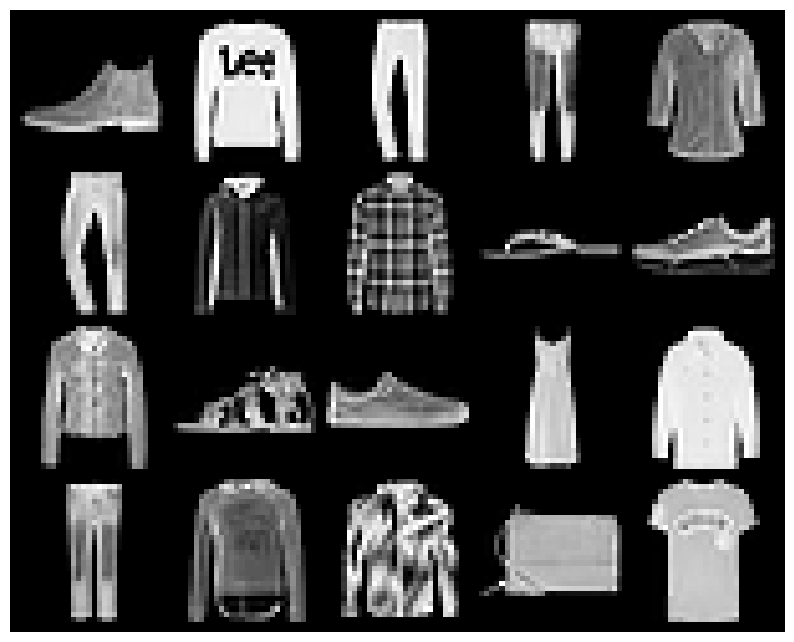

In [11]:
visualize_images(real_samples[:n_display])

In [12]:
from eval_metrics import *

In [13]:
precision_DM, recall_DM = precision_recall(real_samples, DM_samples)
kid_DI = kid_score(real_samples, DM_samples)

precision_g_pretrained, recall_g_pretrained = precision_recall(real_samples, gen_samples_pretrained)
kid_g_pretrained = kid_score(real_samples, gen_samples_pretrained)

precision_g_DI, recall_g_DI = precision_recall(real_samples, gen_samples_DI)
kid_g_DI = kid_score(real_samples, gen_samples_DI)

/home/marceau/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/marceau/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/marceau/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/marceau/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a

In [14]:
precision_recall_kid = {
    "DM": [precision_DM, recall_DM, kid_DI],
    "gen_pretrained": [precision_g_pretrained, recall_g_pretrained, kid_g_pretrained],
    "gen_DI": [precision_g_DI, recall_g_DI, kid_g_DI],
}

df_scores = pd.DataFrame.from_dict(precision_recall_kid, orient='index', columns=['precision', 'recall', 'KID'])

# Display the DataFrame
print(df_scores)

                precision  recall       KID
DM                   0.71    0.59  0.030831
gen_pretrained       0.60    0.48  0.099935
gen_DI               0.50    0.28  0.124624


## Training progress analysis

As mentioned in the report, we observed the same behavior happening more or less quickly wether we changed the update strategy (possibly several updates of one model per round0) or changed the learning rates. Here is what we observed. We ran a model DI with default parameters for 150 rounds and saved a model to sample from every 15 epochs. We also saved the training logs.

For the logs:

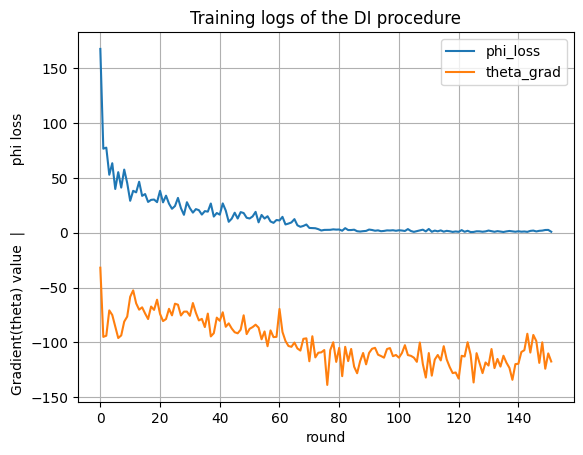

In [15]:
DI_logs = pd.read_csv('DI_models/tracking/logs_default.csv')


DI_logs.plot('round')
plt.grid(True)
plt.ylabel("Gradient(theta) value  |               phi loss                 ")
plt.title("Training logs of the DI procedure")
plt.savefig("figures/DI_training_logs.jpg", dpi=150)
plt.show()


As we can see, the DM converges but the generator keeps requiring agressive updates. All in all, the generator doesn't learn. In fact as we will see, the generator forgets. Let's sample 5 images from each of our models.

In [16]:
dico_list = []

for file in os.listdir('DI_models/tracking/'):
    if file[-3:] != 'pth':
        continue
    round_ = int(file[27:-4])
    path = f"DI_models/tracking/{file}"
    generator = load_generator(path, latent_dim, img_channels, hidden_dim, device)
    samples_DI = sample_generator(generator, 5, latent_dim, device)

    precision, recall = precision_recall(real_samples, samples_DI)
    kid = kid_score(real_samples, samples_DI)


    dico_list.append({
        'round': round_,
        'samples': samples_DI,
        'precision': precision,
        'recall': recall,
        'kid': kid}
    )


/tmp/ipykernel_66949/2354721227.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(model_path, map_location=device))
/home/marceau/.lo

In [17]:
df = pd.DataFrame([{k: v for k, v in d.items() if k != 'samples'} for d in dico_list])
df.set_index('round', inplace=True)
df.sort_index(inplace=True)
df

,precision,recall,kid
round,,,
0,1.0,0.11,0.110664
15,1.0,0.09,0.134877
30,1.0,0.11,0.121929
45,1.0,0.12,0.178000
60,1.0,0.05,0.182298
75,1.0,0.03,0.509133
90,0.8,0.03,0.523848
105,0.8,0.03,0.535239
120,0.8,0.03,0.532563


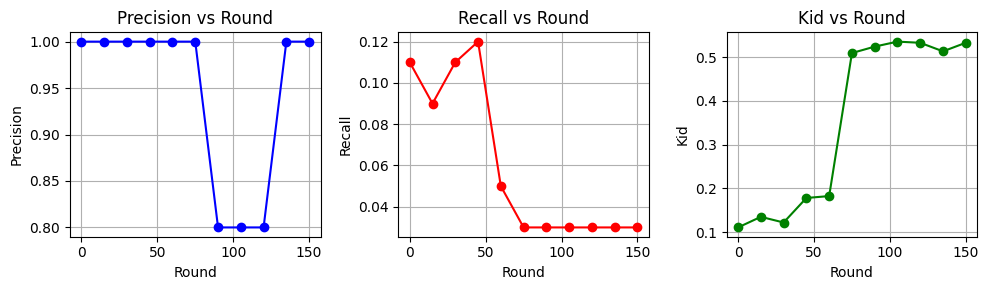

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

axes[0].plot(df.index, df['precision'], 'b-o')
axes[0].set_title('Precision vs Round')
axes[0].set_xlabel('Round')
axes[0].set_ylabel('Precision')
axes[0].grid(True)

axes[1].plot(df.index, df['recall'], 'r-o')
axes[1].set_title('Recall vs Round')
axes[1].set_xlabel('Round')
axes[1].set_ylabel('Recall')
axes[1].grid(True)

axes[2].plot(df.index, df['kid'], 'g-o')
axes[2].set_title('Kid vs Round')
axes[2].set_xlabel('Round')
axes[2].set_ylabel('Kid')
axes[2].grid(True)

plt.tight_layout()
plt.savefig('figures/DI_scores.jpg', dpi=150)
plt.show()

The slight improvement in the recall is a fluke. Running this script several times will lead to different results. Overall, the procedure hurts the generator, as observed qualitatively below.

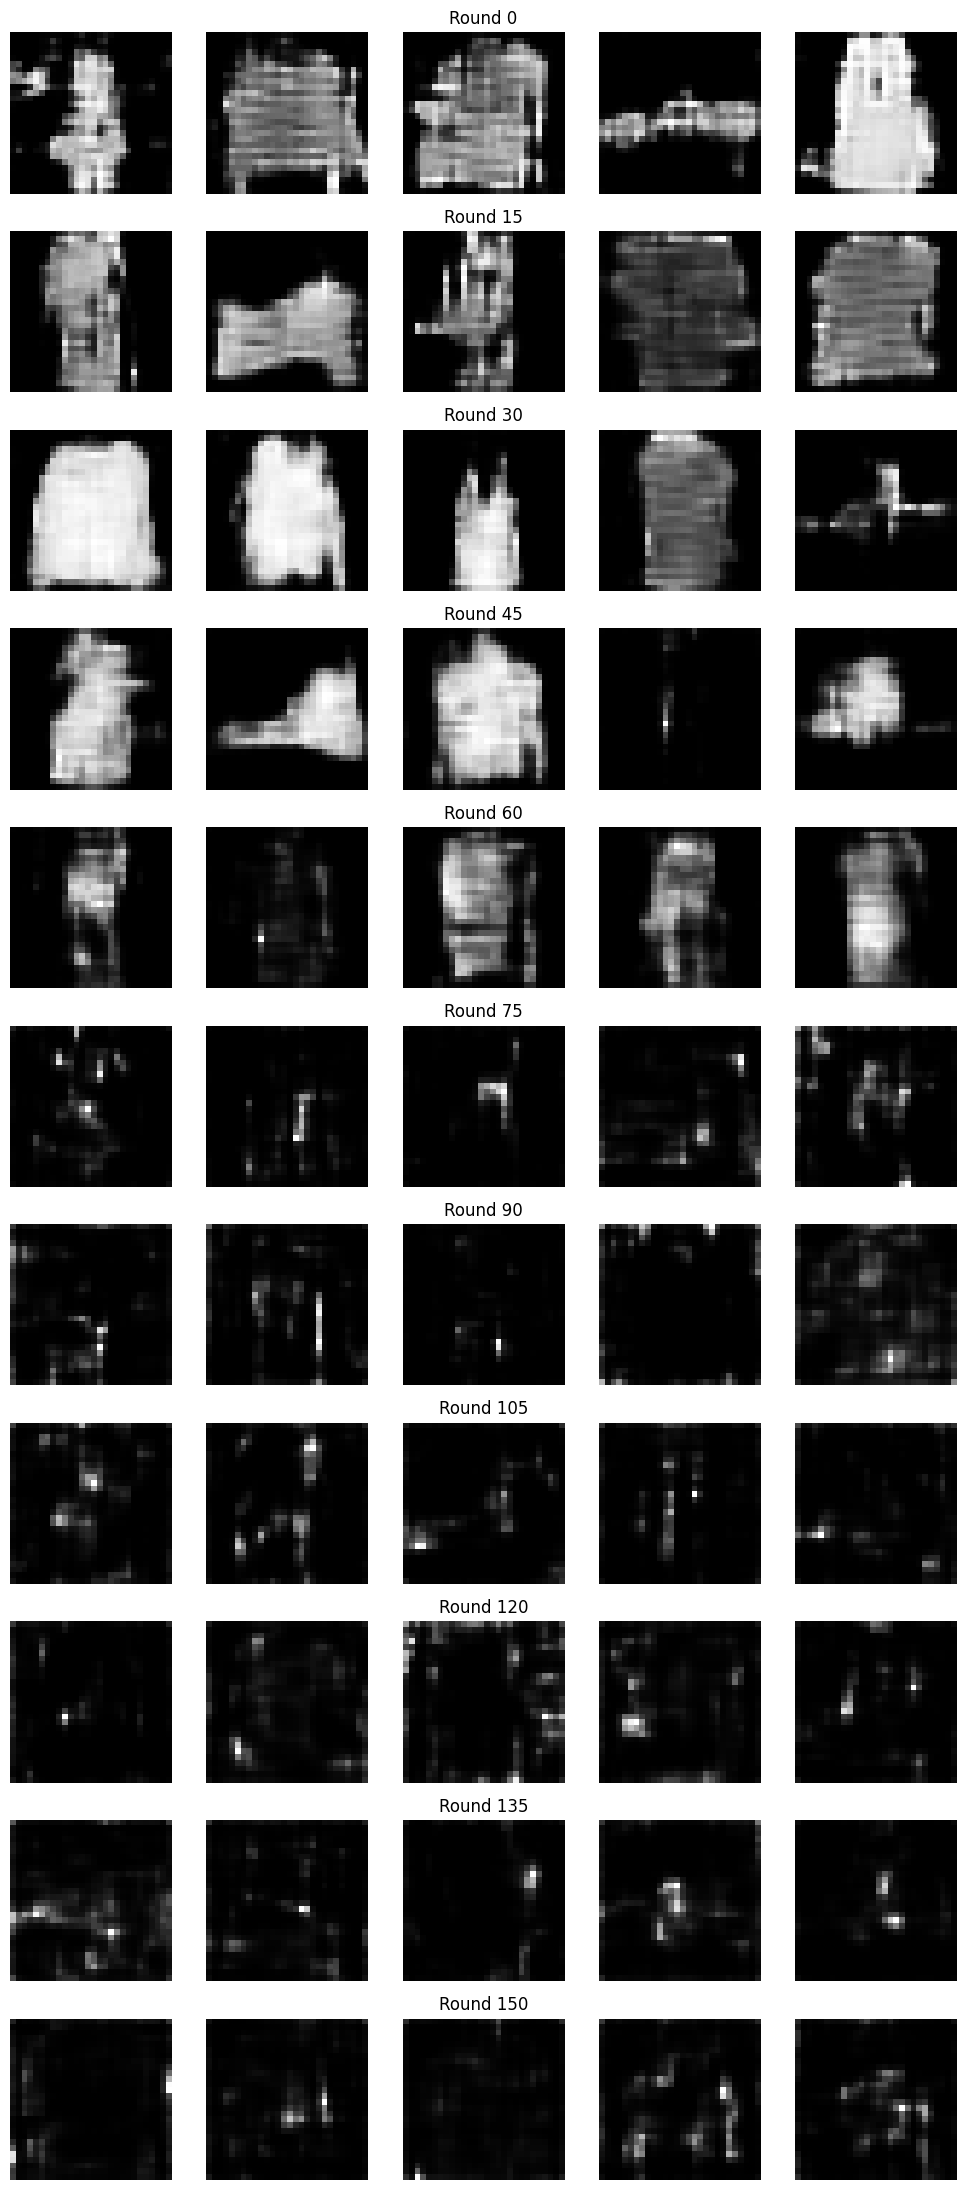

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Sample dico_list (replace with actual data)
# Assuming 'samples' contains tensors of shape (5, 1, 28, 28)
dico_list = sorted(dico_list, key=lambda x: x['round'])  # Sort by 'round'

# Extract rounds and sample tensors in sorted order
rounds = [d['round'] for d in dico_list]
samples = [d['samples'] for d in dico_list]  # Assuming 5x1x28x28 tensors

# Create the figure with 11 rows and 5 columns
fig, axes = plt.subplots(len(samples), 5, figsize=(10, 22))

# Loop through rows (rounds) and columns (samples per round)
for i, (rnd, sample_set) in enumerate(zip(rounds, samples)):
    for j in range(5):
        # Remove the single channel dimension and plot the image
        img = sample_set[j, 0, :, :]  # Shape (1, 28, 28) -> (28, 28)
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')  # Hide axis

    # Add round number label on the left side
    axes[i, 2].set_title(f'Round {rnd}')

# Adjust layout to fit everything nicely
plt.tight_layout()
plt.savefig('figures/viz_DI.jpg', dpi=150)
plt.show()


It is clear that the implementation does not yield satisfying results in our case. We tried various set ups, all leading to this very observation, just at different velocities.